# Project 'WHO suicide statistics predictions'

WHO suicide statistics predictions for European Union country-members. 
WHO Suicide Statistics data (WHO Mortality Database) for each EU member country, year, age groups and sex. 
Temporal dependencies in some cases (for Portugal and Slovenia) do not cover all periods of membering in the EU.

Additional metrics/features for primary WHO Mortality Database :
* GDP per capita(from World Bank Open Data);
* GINI index(from World Bank Open Data);
* Foreign Exchange Reserves (from World Bank Open Data);
* Unemployment (from World Bank Open Data);
* Inflation Rate (from World Bank Open Data);
* ARMS export (from World Bank Open Data);
* ARMS import (from World Bank Open Data);
* Life length (from World Bank Open Data);
* Corruption perception index (from Transparency);
* Average January weather temperature (from Climate Change Knowledge Portal);
* Average July weather temperature (from Climate Change Knowledge Portal).

## Loading data set and choosing random seed

In [1]:
from ml_functions import *

Make results reproducible by emphasizing random seed.

In [2]:
np.random.seed(seed=158)

## Loading data set

In [3]:
path_material = pathlib.Path('data\\raw_data.csv')

In [4]:
df_raw = pd.read_csv(path_material, low_memory=False)

## Data pre-processing

Brief overall data set description.

In [5]:
df_raw.describe()

,year,population,foreign_exch_reserve,GPD_per_cap,Unemployment,Inflation_rate,Life_length_expectancy,GINI,ARMS_export,ARMS_import,Corruption_perception,Temperature_JAN,Temperature_JUL,suicides_no
count,7248.000000,7.248000e+03,7.176000e+03,7248.000000,7092.000000,7248.000000,7248.000000,4656.000000,4.872000e+03,6.384000e+03,4764.000000,7248.000000,7248.000000,7248.000000
mean,2001.774834,1.743408e+06,3.469842e+10,26893.020251,8.820021,3.470996,77.562979,31.333763,6.209064e+08,2.277538e+08,21.985516,1.868540,19.271537,217.996551
std,10.055130,2.235278e+06,3.911449e+10,18015.963059,4.311936,3.911775,2.718098,3.608685,8.498247e+08,3.152652e+08,26.615663,5.127656,3.454063,425.938170
min,1979.000000,5.900000e+03,9.746575e+07,3861.948500,1.482400,-4.478103,70.865854,23.000000,0.000000e+00,0.000000e+00,3.330000,-16.194000,12.571100,0.000000
25%,1995.000000,3.024238e+05,6.400005e+09,13585.207562,5.856900,1.417741,75.475287,28.200000,2.500000e+07,2.400000e+07,6.100000,-1.093000,16.649850,9.000000
50%,2004.000000,7.447485e+05,2.160458e+10,23102.007735,7.865600,2.452733,77.636585,31.350000,2.080000e+08,1.045000e+08,8.000000,2.732625,18.887950,63.000000
75%,2010.000000,2.538383e+06,4.807903e+10,35575.159547,10.554500,4.053958,79.793293,34.300000,9.510000e+08,2.865000e+08,42.000000,5.044645,21.743575,214.000000
max,2016.000000,1.314881e+07,2.490000e+11,118823.648400,27.466200,24.506067,83.229268,39.000000,4.037000e+09,2.167000e+09,92.000000,22.723500,29.786000,3427.000000


### Refactor columns titles

Initialize **refactor_titles()** function (it changes all titles to lower cases along with substituting and dropping several uncommon characters) on the DataFrame's columns.

In [6]:
df_raw.columns = refactor_titles(df_raw)

Substituotion of " " occured 0 times.
Substituotion of "-" occured 0 times.
Substituotion of ":" occured 0 times.


### Update 'corruption perception' feature as evaluation changed from 2012

After 2012 Corruption perception evaluation changes from range 10 to range 100.
In order to generalize column, all values after 2012 will be divided by 10.

In [7]:
df_raw['corruption_perception'] = df_raw['corruption_perception'].apply(lambda x: x/10 if x > 10 else x)

### NaN values | part 1/2

Check the DataFrame for null-values.

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 7248 non-null   object 
 1   year                    7248 non-null   int64  
 2   sex                     7248 non-null   object 
 3   age                     7248 non-null   object 
 4   population              7248 non-null   int64  
 5   foreign_exch_reserve    7176 non-null   float64
 6   gpd_per_cap             7248 non-null   float64
 7   unemployment            7092 non-null   float64
 8   inflation_rate          7248 non-null   float64
 9   life_length_expectancy  7248 non-null   float64
 10  gini                    4656 non-null   float64
 11  arms_export             4872 non-null   float64
 12  arms_import             6384 non-null   float64
 13  corruption_perception   4764 non-null   float64
 14  temperature_jan         7248 non-null   

####  *ARMS import* and *ARMS export* features

All empty values in both ARMS import and ARMS export columns will be filled with '0', as these countries didn't participate neither in ARMS import nor in ARMS export activities.

In [9]:
df_raw['arms_import'].fillna(0, inplace=True)
df_raw['arms_export'].fillna(0, inplace=True)

#### *Foreign exchange* reserve and *Unemployment* features

**nan_columns_by_country()** function derives column names containing at least one NaN value, puts them into a list, assigns it to a variable, attaches country names where NaN appeared and returns a dictionary with countries.

In [10]:
columns_nan_dict = nan_columns_by_country(df_raw,'country')

* 22 categories in column "country" with at least one NaN in "corruption_perception".
* 1 categories in column "country" with at least one NaN in "foreign_exch_reserve".
* 16 categories in column "country" with at least one NaN in "gini".
* 4 categories in column "country" with at least one NaN in "unemployment".


Function returned 4 columns: 
* foreign_exch_reserve;
* unemployment;
* gini;
* corruption_perception;

Fill NaN values in 'unemployment' column using **fillna()** function as only 4 countries have missing values.

In [11]:
backfilling_nan_by_country(df=df_raw, columns_nan_dict=columns_nan_dict,
                           target_column='unemployment', category_column = 'country')

'NaN values were filled in "unemployment"" column'

Fill NaN values in 'foreign_exch_reserve' column using **fillna()** function as only one country have missing values.

In [12]:
backfilling_nan_by_country(df=df_raw,columns_nan_dict=columns_nan_dict,
                           target_column='foreign_exch_reserve', category_column = 'country')

'NaN values were filled in "foreign_exch_reserve"" column'

#### Remaining NaN columns

Observe using **missing_values()** remaining NaN columns.

Column "gini" has 2592 missing values.
Column "corruption_perception" has 2484 missing values.


<AxesSubplot:>

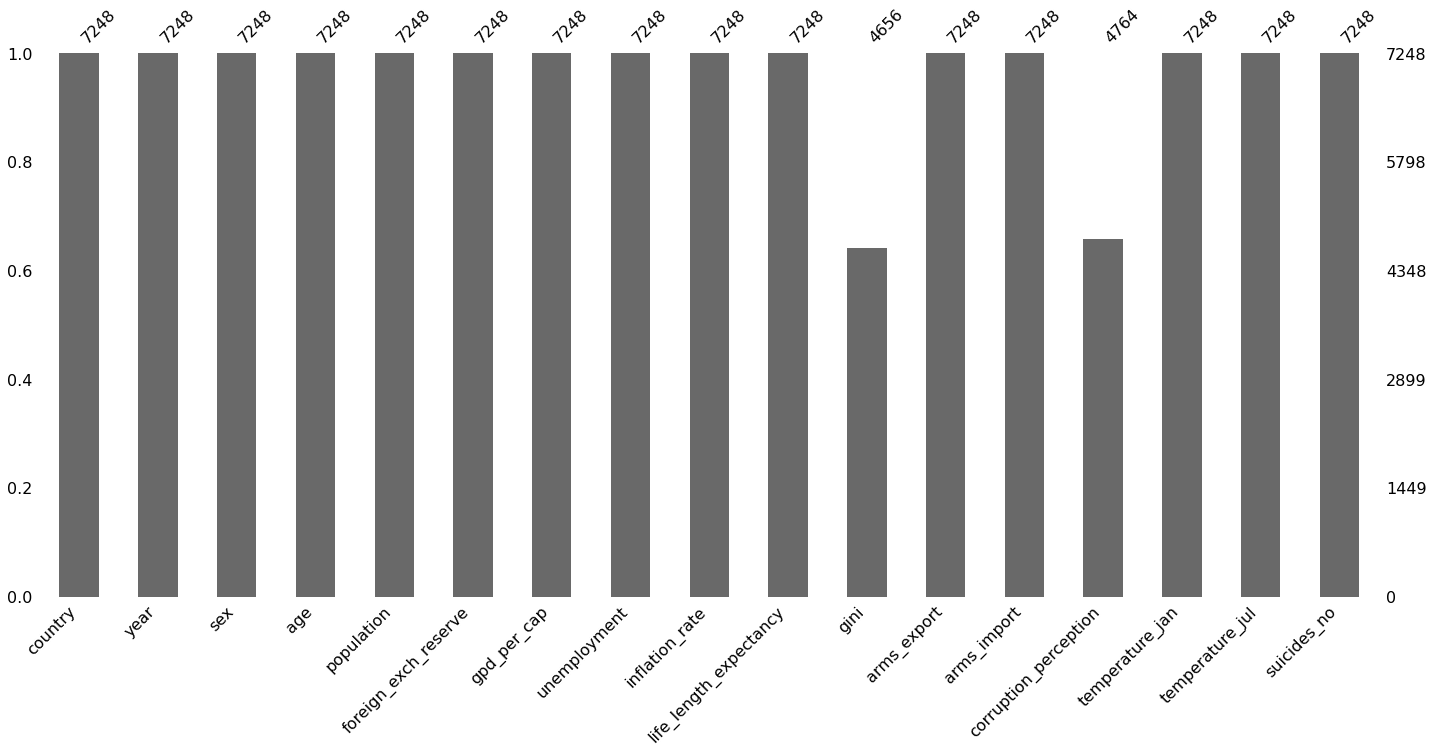

In [13]:
missing_values(df_raw)

***'gini'*** and ***'corruption_perception'*** columns still remain with NaN values.

### Label Encoding

Define binary cardinality columns.

In [14]:
binary_cardinality_cols = [col_name for col_name in df_raw.columns if df_raw[col_name].nunique() < 3 and 
                                                                   df_raw[col_name].dtype == 'object']; 
print(f' Binary cardinality columns: {binary_cardinality_cols}')

 Binary cardinality columns: ['sex']


Next action is Label Encoding for binary cardinality columns.

In [15]:
label_df_raw = df_raw.copy()
label_encoder = LabelEncoder()

for col in binary_cardinality_cols:
    label_df_raw[col] = label_encoder.fit_transform(df_raw[col])

DataFrame first 12 rows overview after Label Encoding.

In [16]:
label_df_raw.head(12)

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
0,Austria,1995,0,15-24 years,495368,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,19
1,Austria,1995,0,25-34 years,678262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,59
2,Austria,1995,0,35-54 years,1065630,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,136
3,Austria,1995,0,5-14 years,460945,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,0
4,Austria,1995,0,55-74 years,843210,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,141
5,Austria,1995,0,75+ years,341098,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,100
6,Austria,1995,1,15-24 years,509262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,134
7,Austria,1995,1,25-34 years,707468,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,237
8,Austria,1995,1,35-54 years,1074328,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,437
9,Austria,1995,1,5-14 years,483644,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,0.0,24000000.0,NaN,-3.3684,18.3665,8


### One-Hot-Encoder

After committing label encoding for binary cardinality columns next mvpe is to check low cardinality columns.
Maximum number of unique values for low cardinality columns is higher than 2 but less than 16.

In [17]:
low_cardinality_cols = [col_name for col_name in df_raw.columns if 2 < df_raw[col_name].nunique() < 16 and 
                                                                   df_raw[col_name].dtype == 'object']; 
print(f' Low cardinality columns: {low_cardinality_cols}')

 Low cardinality columns: ['age']


Adjust One-Hot-Encoding and reform low cardinality columns.

In [18]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
OH_cols_df = pd.DataFrame(OH_encoder.fit_transform(df_raw[low_cardinality_cols]))

OH_cols_df.index = df_raw.index 
OH_cols_df.rename(columns = {0: '15-24 years',
                             1: '25-34 years',
                             2: '35-54 years',
                             3: '5-14 years',
                             4: '55-74 years',
                             5: '75+ years'}, inplace=True)

num_df = label_df_raw.drop(low_cardinality_cols, axis=1) 
OH_df = pd.concat([num_df,OH_cols_df], axis=1)

DataFrame overview after One-Hot-Encoding.

In [19]:
OH_df

,country,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,...,corruption_perception,temperature_jan,temperature_jul,suicides_no,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
0,Austria,1995,0,495368,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,19,1.0,0.0,0.0,0.0,0.0,0.0
1,Austria,1995,0,678262,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,59,0.0,1.0,0.0,0.0,0.0,0.0
2,Austria,1995,0,1065630,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,136,0.0,0.0,1.0,0.0,0.0,0.0
3,Austria,1995,0,460945,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,0,0.0,0.0,0.0,1.0,0.0,0.0
4,Austria,1995,0,843210,2.336874e+10,30325.84958,4.3473,2.243367,76.668293,31.1,...,NaN,-3.36840,18.3665,141,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,United Kingdom,2015,1,4408293,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,596,0.0,1.0,0.0,0.0,0.0,0.0
7244,United Kingdom,2015,1,8692440,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,1579,0.0,0.0,1.0,0.0,0.0,0.0
7245,United Kingdom,2015,1,3840476,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,4,0.0,0.0,0.0,1.0,0.0,0.0
7246,United Kingdom,2015,1,6716557,1.480000e+11,44974.83188,5.3003,0.368047,80.956098,33.2,...,8.1,3.87941,14.5338,906,0.0,0.0,0.0,0.0,1.0,0.0


### Train and Test set split

Divide all data into ***test*** as 20% and ***train*** as 80% of the data set.  

In [20]:
msk = np.random.rand(len(df_raw)) < 0.8

Initialize two DataFrames according to previous separation.

In [21]:
train = OH_df[msk]
test = OH_df[~msk]

Split train data set into ***X*** and ***y*** and test data set into ***X_test*** and ***y_test***.

In [22]:
X,y = train.drop(columns=['suicides_no']), train['suicides_no']
X_test,y_test = test.drop(columns=['suicides_no']), test['suicides_no']

### Train and Validation set split

Split into ***train*** as 75% and ***validation*** as 25% of the both ***X*** and ***y*** set parts and print their shapes.

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=158)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)

Train set: (4304, 21) (4304,)
Validation set: (1435, 21) (1435,)


### NaN values | part 2/2

#### Drop 'country' column and  use Simple Imputer

Impute the remaining two columns: ***'gini'*** and ***'corruption_perception'***.
Restore columns names and indexes. Drop *country* column.
Imputing the mean value should be after splitting the data set into train/validation/test in order not to leak data.

In [24]:
features = X_train.columns[1:]

my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[features]))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[features]))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test[features]))

imputed_X_train.columns = X_train[features].columns
imputed_X_valid.columns = X_valid[features].columns
imputed_X_test.columns = X_test[features].columns

imputed_X_train.index = X_train[features].index
imputed_X_valid.index = X_valid[features].index
imputed_X_test.index = X_test[features].index

#### Changing several formats

Form a dictionary for a DataFrame columns with less PC memory consuming data types.

In [25]:
formats = {'sex': 'int8','15-24 years': 'int8',
           '25-34 years': 'int8','35-54 years': 'int8',
           '5-14 years': 'int8','55-74 years': 'int8',
           '75+ years': 'int8', 'year': 'int32'}

BEFORE PRE-PROCESSING

In [26]:
X_train[:2] 

,country,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,...,arms_import,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
2828,France,2010,1,8518205,1.660000e+11,40638.334000,8.8713,1.531123,81.663415,33.7,...,103000000.0,6.8,1.06260,20.9197,0.0,0.0,1.0,0.0,0.0,0.0
4011,Italy,1985,0,3898700,3.739657e+10,7990.686562,9.4065,9.205991,75.470732,NaN,...,206000000.0,NaN,0.89887,21.7534,0.0,0.0,0.0,1.0,0.0,0.0


#### Final train/validation/test

Construct final train/validation/test DataFrames.

In [27]:
X_train = imputed_X_train.copy().astype(formats)
X_valid = imputed_X_valid.copy().astype(formats)
X_test = imputed_X_test.copy().astype(formats)

AFTER PRE-PROCESSING

In [28]:
X_train[:2]

,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years
2828,2010,1,8518205.0,1.660000e+11,40638.334000,8.8713,1.531123,81.663415,33.700000,866000000.0,103000000.0,6.800000,1.06260,20.9197,0,0,1,0,0,0
4011,1985,0,3898700.0,3.739657e+10,7990.686562,9.4065,9.205991,75.470732,31.346157,920000000.0,206000000.0,6.768767,0.89887,21.7534,0,0,0,1,0,0


Final check for train/validation/test set shapes.

In [29]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_valid.shape,  y_valid.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4304, 20) (4304,)
Validation set: (1435, 20) (1435,)
Test set: (1509, 20) (1509,)


### Random Forest model

Initialize Random Forest model and print all scores.

In [30]:
forest_model = RandomForestRegressor(n_jobs=-1, random_state=158,oob_score=True)
forest_model.fit(X_train, y_train)  
print_score(forest_model, X_train, X_valid,y_train, y_valid)

('RMSE Train set: 40.46307338, RMSE Validation set: 104.08743444, '
 'r² Train set: 0.99081997, r² Validation set:0.94099394,         '
 'MAE Train set: 14.96038801, MAE Validation set: 38.88105226')


### Linear Regression model

Initialize Linear Regression baseline model and print all scores.

In [31]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print_score(regr,X_train, X_valid,y_train, y_valid)

('RMSE Train set: 260.86301673, RMSE Validation set: 271.80050038, '
 'r² Train set: 0.61845014, r² Validation set:0.59765327,         '
 'MAE Train set: 159.38991589, MAE Validation set: 164.793297')


Linear Regression Coefficients and Intercept value along with column names.

In [32]:
coefs = list(regr.coef_)
col_names = list(X_train.columns)
val = zip(col_names,coefs)
for coef_ in val:
    print(coef_)
print()
print ('Intercept: ',regr.intercept_)

('year', -0.7897392493634116)
('sex', 215.3742093794777)
('population', 0.00011511300141388205)
('foreign_exch_reserve', 5.050452346601324e-10)
('gpd_per_cap', 0.0006340483893966887)
('unemployment', 0.2877693543616852)
('inflation_rate', -7.924095389724259)
('life_length_expectancy', -18.301630583978934)
('gini', -8.661009978887858)
('arms_export', 5.703109439015665e-08)
('arms_import', -9.055167198724951e-08)
('corruption_perception', 4.116805003670106)
('temperature_jan', -3.5280112291505543)
('temperature_jul', 7.963009777002055)
('15-24 years', -83.52023365665859)
('25-34 years', -24.337837939974307)
('35-54 years', 88.14604294531544)
('5-14 years', -169.9008140282418)
('55-74 years', 108.87013385043984)
('75+ years', 80.74270882911955)

Intercept:  2990.6269708235673


####  Robust Scaler on Linear Regression model

Use RobustScaler() for scaling ***X_train*** and ***X_valid***

In [33]:
scaler = RobustScaler()
X_train_robust_scaler = scaler.fit_transform(X_train.copy())
X_valid_robust_scaler = scaler.transform(X_valid.copy())

regr_vol_2 = linear_model.LinearRegression()
regr_vol_2.fit(X_train_robust_scaler, y_train)

print_score(regr_vol_2,X_train_robust_scaler, X_valid_robust_scaler,y_train, y_valid)

('RMSE Train set: 260.86301673, RMSE Validation set: 271.8004372, '
 'r² Train set: 0.61845014, r² Validation set:0.59765345,         '
 'MAE Train set: 159.38977354, MAE Validation set: 164.79312944')


#### MinMax Scaler on Linear Regression model

Use MinMaxScaler() for scaling ***X_train*** and ***X_valid***

In [34]:
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train.copy())
X_valid_norm = norm.transform(X_valid.copy())

regr_vol_3 = linear_model.LinearRegression()
regr_vol_3.fit(X_train_norm, y_train)

print_score(regr_vol_3,X_train_norm, X_valid_norm,y_train, y_valid)

('RMSE Train set: 260.88942496, RMSE Validation set: 271.66029976, '
 'r² Train set: 0.61837288, r² Validation set:0.59806824,         '
 'MAE Train set: 159.62523234, MAE Validation set: 164.74425087')


#### Standard Scaler on Linear Regression model

Use StandardScaler() for scaling ***X_train*** and ***X_valid***

In [35]:
standard_scaler = StandardScaler()
X_train_standard_scaler = standard_scaler.fit_transform(X_train.copy())
X_valid_standard_scaler = standard_scaler.transform(X_valid.copy())

regr_vol_4 = linear_model.LinearRegression()
regr_vol_4.fit(X_train_standard_scaler, y_train)

print_score(regr_vol_4,X_train_standard_scaler, X_valid_standard_scaler,y_train, y_valid)

('RMSE Train set: 260.86299656, RMSE Validation set: 271.79908062, '
 'r² Train set: 0.6184502, r² Validation set:0.59765747,         '
 'MAE Train set: 159.38857959, MAE Validation set: 164.79080653')


None of above used scaling methods did not improve results much. As I was told on https://stackoverflow.com/ (by user ***Ben Reiniger***): Scaling does not affect an unpenalized regression. It can improve convergence of the solver, but if the model is converging satisfactorily on the raw data, the results will be the same.

####  Linear Regression model's Heatmap

Heatmap shows correlation between independent variables. 
According to result some vairables can be dropped others can be merged.

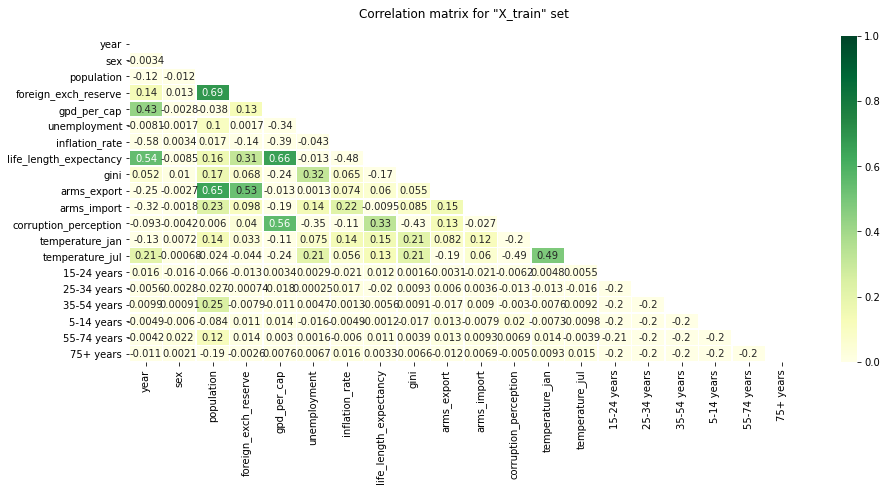

In [36]:
f, ax = plt.subplots(figsize=(15, 6))
mask_corr = np.triu(np.ones_like(X_train.corr(method='pearson'), dtype=bool))
sns.heatmap(X_train.corr(method='pearson'), annot=True, mask=mask_corr, robust=False,cmap='YlGn', 
                                                                linewidths=.6, ax=ax, vmin=0, vmax=1)
plt.title('Correlation matrix for "X_train" set', y=1.04)
plt.show()

#### Linear Regression model's Validation set predictions scatter plot

Compare predictions and real values using scatter plot and figure out how many negative predictions occurred.

Positive "y" predicitons: 1084
Negative "y" predictions: 351


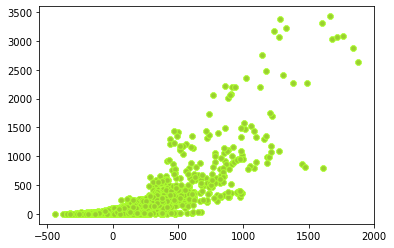

In [37]:
plt.scatter(regr.predict(X_valid),y_valid.to_numpy(),color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(-500,2200,500)))
preds_lin = regr.predict(X_valid)
print(f'Positive "y" predicitons: {preds_lin[preds_lin>=0].size}')
print(f'Negative "y" predictions: {preds_lin[preds_lin<0].size}')

<br>Inferring very terrible predictions for Linear Regression model, even negative ones for low dependent variable's values.</br> <br>Use a zip() iterator and take the first ten values from *'X_valid' predictions and first ten values from *'y_valid'* and print them out.</br>

In [38]:
pprint(tuple(zip(list(regr.predict(X_valid)[:10]),(list(y_valid.to_numpy()[:10])))))

((-230.21485151366778, 0),
 (87.89627323287323, 53),
 (-223.64576155183386, 3),
 (128.01080020063455, 17),
 (-332.05814228307963, 1),
 (-44.65449690454261, 16),
 (99.59318735159422, 71),
 (246.63179185090712, 132),
 (-86.56552419252739, 15),
 (226.63119149226577, 111))


Take the log of the value plus 1 of the ***y_train*** and ***y_valid***, as data set *y* has *zero* values and initialize final Linear Regression model. 

In [39]:
y_train_log = np.log1p(np.clip(y_train.copy(), 0, None))
y_valid_log = np.log1p(np.clip(y_valid.copy(), 0, None))

regr_vol_5 = linear_model.LinearRegression()
regr_vol_5.fit(X_train, y_train_log)
print_score_log(regr_vol_5,X_train, X_valid,y_train_log, y_valid_log)

('RMSE_Train_set: 865.59686638, RMSE_Validation_set: 877.38524479, '
 'r²_Train_set: 0.81941684, r²_Validation_set:0.81432779,          '
 'MAE_Train_set: 167.06285298, MAE_Validation_set: 156.33280553')


<br>Getting better r² and MAE but quite lower RMSE value.</br>
<br>Need to compare predictions after logarithmic actions and real values using scatter plot and figure out if any outliers appear.</br>

Positive "y" predicitons: 1397
Negative "y" predictions: 38


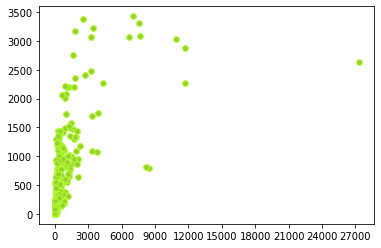

In [41]:
plt.scatter(np.expm1(regr_vol_5.predict(X_valid)),np.expm1(y_valid_log),color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(0,28000,3000)))
preds_lin = np.expm1(regr_vol_5.predict(X_valid))
print(f'Positive "y" predicitons: {preds_lin[preds_lin>=0].size}')
print(f'Negative "y" predictions: {preds_lin[preds_lin<0].size}')

One outlier of value about 27,328 occurs. (exact value is 27,327.513086656043, index 856) 

### DecisionTreeRegressor model

Loop in order to find best 'max_leaf_nodes' parameter's argument.

In [42]:
for max_leaf_nodes in [5, 50, 250, 350, 500]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_valid,y_train, y_valid)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:%d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5  		 Mean Absolute Error:144
Max leaf nodes: 50  		 Mean Absolute Error:81
Max leaf nodes: 250  		 Mean Absolute Error:53
Max leaf nodes: 350  		 Mean Absolute Error:51
Max leaf nodes: 500  		 Mean Absolute Error:49


Initialize DecisionTreeRegressor model with 'max_leaf_nodes' as *350* and print all scores.

In [43]:
model = DecisionTreeRegressor(max_leaf_nodes=350, random_state=158, max_features=0.5)
model.fit(X_train, y_train)
print_score(model,X_train, X_valid,y_train, y_valid)

('RMSE Train set: 26.98238658, RMSE Validation set: 154.03288966, '
 'r² Train set: 0.99591787, r² Validation set:0.87078084,         '
 'MAE Train set: 17.89357047, MAE Validation set: 48.25040933')


### K-Nearest Neighbors model

Loop and visualize to find K value for the model comparing accuracy at each K value.

Maximum accuracy: 0.06898954703832752 at K Value = 95


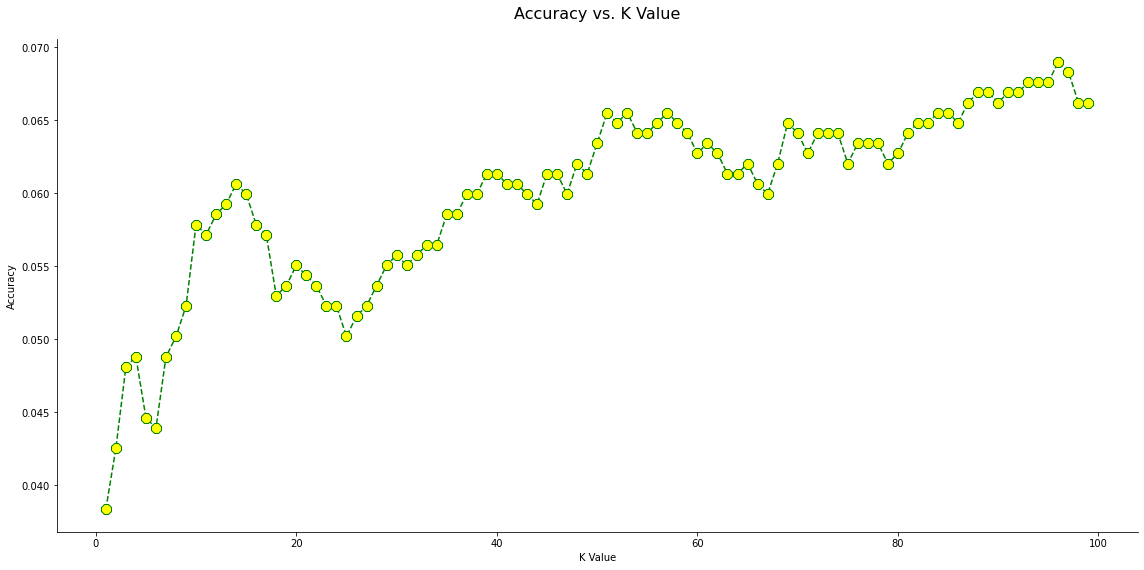

In [44]:
acuracy_list = []  

for i in range(1,100):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    preds = neigh.predict(X_valid)
    acuracy_list.append(metrics.accuracy_score(y_valid, preds))
    
plt.figure(figsize=(16,8))
plt.plot(range(1,100),acuracy_list,color = 'green',linestyle='dashed', 
         marker='8',markerfacecolor='yellow', markersize=10)
[plt.gca().spines[loc].set_visible(False) for loc in ['top', 'right']]
plt.title('Accuracy vs. K Value', fontsize=16, y=1.03)
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.tight_layout()
print("Maximum accuracy:",max(acuracy_list),"at K Value =",acuracy_list.index(max(acuracy_list)))

Initialize K-Nearest Neighbors model with K value *95* and print all scores.

In [45]:
neigh = KNeighborsClassifier(n_neighbors = 95,n_jobs=-1)
neigh.fit(X_train,y_train)
print_score(neigh, X_train, X_valid,y_train, y_valid)

('RMSE Train set: 474.08699552, RMSE Validation set: 473.09522434, '
 'r² Train set: 0.07272305, r² Validation set:0.06759582,         '
 'MAE Train set: 219.46026952, MAE Validation set: 203.37979094')


#### Scaling for Logistic Regression model and Support Vector Regression model

Scale ***train*** and ***validation*** data to \[-1,1\] in order to increase model speed.

In [46]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_scaler = scaling.transform(X_train)
X_valid_scaler = scaling.transform(X_valid)

### Logistic Regression model

Loop through 3 solvers to evaluate accuracy and choose the best performed for the Logistic Regression model.

In [47]:
# list_lr = ['newton-cg', 'liblinear', 'sag']

# for solver in list_lr:
#     lr = linear_model.LogisticRegression(C=0.9, solver=solver).fit(X_train_scaler,y_train)
#     y_hat = lr.predict(X_valid_scaler)
#     mean_acc = accuracy_score(y_valid,y_hat)
#     print(f'"{solver}" kernel model accuracy score: {mean_acc.round(6)}')

Logistic Regression model with solver as "*newton-cg*" and model's score.

In [48]:
# logreg = linear_model.LogisticRegression(C=0.9, solver='newton-cg')
# logreg.fit(X_train_scaler,y_train)
# print_score_scaler(logreg, X_train_scaler, X_valid_scaler,y_train, y_valid) 

### Support Vector Regression model

Loop through 4 kernels to evaluate accuracy and choose the best performed for Support Vector Regression model.

In [49]:
# list_svr = ['linear', 'rbf', 'sigmoid','poly']

# for model in list_svr:
#     svm = SVC(kernel=model).fit(X_train_scaler,y_train)
#     y_hat = svm.predict(X_valid_scaler)
#     mean_acc = accuracy_score(y_valid,y_hat)
#     print(f'{model} kernel model accuracy score: {mean_acc.round(6)}')

Support Vector Regression model with kernel as "*poly*" and model's score.

In [50]:
# svm = SVC(kernel='poly')
# svm.fit(X_train_scaler,y_train)
# print_score_scaler(svm, X_train_scaler, X_valid_scaler,y_train, y_valid) 

## Scoreboard

####  <center> -=- Validation Set Scoreboard -=-</center>

| Model algorithm               |  RMSE    |    r²    |    MAE   |
| ----------------------------- | -------- | -------- | -------- |
| Random Forest                 | 104.0874 | 0.9410   |  38.8811 |
| DecisionTreeRegressor         | 154.0329 | 0.8708   |  48.2504 |
| LinearRegression              | 271.7991 | 0.5977   | 164.7908 |
| LinearRegression (with y log) | 877.3852 | 0.8143   | 156.3328 | 
| SVM                           | 313.7996 | 0.0927   | 122.8836 |
| LogisticRegression            | 296.1698 | 0.0878   | 124.3979 |
| K-Nearest Neighbors           | 473.0952 | 0.0676   | 203.3798 |

### To-Do list:

1. Tune Random Forest hyperparametres with fast.ai functions; [till 2021-01-16]
2. XGboost model ; [till 2021-01-16]
3. Catboost for countries (?) [till 2021-01-23]
4. SGD/LightGBM  model (?) [till 2021-01-23]

## <span style="color:teal"> Case 856 aka outlier from Linear Regression</span>

In [51]:
preds = np.expm1(regr_vol_5.predict(X_valid))

In [52]:
x = list(preds) 
x.index(27327.513086656043) # 856

856

In [53]:
x_856_case = X_valid.copy()

In [54]:
x_856_case['num'] = list(range(1,1436,1))

In [55]:
x_856_case[x_856_case['num'] == 856 ]

,year,sex,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,...,corruption_perception,temperature_jan,temperature_jul,15-24 years,25-34 years,35-54 years,5-14 years,55-74 years,75+ years,num
4032,1987,0,4637300.0,6.248896e+10,14234.72865,10.7225,4.747285,76.219512,34.5,617000000.0,...,6.768767,2.45167,21.6348,1,0,0,0,0,0,856


In [56]:
df_raw.iloc[[4032,4044]]

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
4032,Italy,1987,female,15-24 years,4637300,6.248896e+10,14234.72865,10.7225,4.747285,76.219512,34.5,617000000.0,183000000.0,NaN,2.45167,21.6348,63
4044,Italy,1988,female,15-24 years,4613100,6.206705e+10,15744.66127,10.9745,5.058247,76.370732,NaN,386000000.0,179000000.0,NaN,6.25722,21.9994,65


In [57]:
case_4032 = df_raw[(df_raw['age'] == '15-24 years') & (df_raw['country'] == 'Italy') & (df_raw['sex'] == 'female')]

In [58]:
case_4032.head()

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
3936,Italy,1979,female,15-24 years,4178700,5.235400e+10,6990.285794,7.64,14.798574,74.002683,NaN,1.303000e+09,605000000.0,NaN,2.47147,20.1819,70
3948,Italy,1980,female,15-24 years,4257400,6.242784e+10,8456.918982,7.53,21.064168,73.943171,NaN,1.168000e+09,479000000.0,NaN,3.18231,18.8625,101
3960,Italy,1981,female,15-24 years,4328200,4.663544e+10,7622.833328,9.03,17.969299,74.353902,NaN,1.715000e+09,133000000.0,NaN,1.70726,19.4005,72
3972,Italy,1982,female,15-24 years,4405200,4.455289e+10,7556.523429,9.03,16.480415,74.814634,NaN,1.689000e+09,251000000.0,NaN,4.42538,21.8611,73
3984,Italy,1983,female,15-24 years,4492000,4.554004e+10,7832.575389,8.57,14.646577,74.640244,NaN,1.183000e+09,307000000.0,NaN,4.18856,22.8564,58


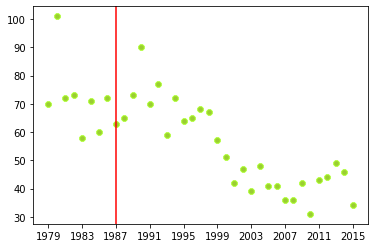

In [59]:
plt.scatter(case_4032['year'],case_4032['suicides_no'] ,color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(1979,2017,4)))
plt.axvline(1987,color='red')
preds_lin = np.expm1(regr_vol_5.predict(X_valid))

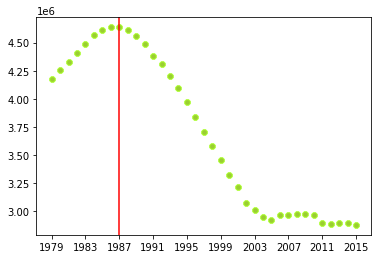

In [60]:
plt.scatter(case_4032['year'],case_4032['population'] ,color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(1979,2017,4)))
plt.axvline(1987,color='red')
preds_lin = np.expm1(regr_vol_5.predict(X_valid))

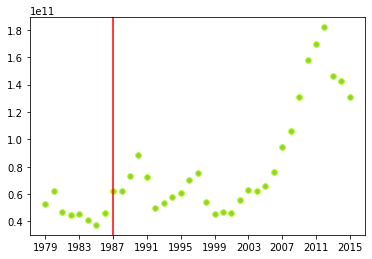

In [61]:
plt.scatter(case_4032['year'],case_4032['foreign_exch_reserve'] ,color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(1979,2017,4)))
plt.axvline(1987,color='red')
preds_lin = np.expm1(regr_vol_5.predict(X_valid))

In [62]:
case_3503 = df_raw[(df_raw['age'] == '75+ years') & (df_raw['country'] == 'Hungary') & (df_raw['sex'] == 'male')]

In [63]:
case_3503

,country,year,sex,age,population,foreign_exch_reserve,gpd_per_cap,unemployment,inflation_rate,life_length_expectancy,gini,arms_export,arms_import,corruption_perception,temperature_jan,temperature_jul,suicides_no
3359,Hungary,2004,male,75+ years,218145,1.596539e+10,10285.79363,5.8321,6.744347,72.648780,29.9,0.0,72000000.0,4.80,-2.64430,20.6158,262
3371,Hungary,2005,male,75+ years,222774,1.860283e+10,11200.57695,7.1885,3.561517,72.648780,34.7,82000000.0,13000000.0,5.00,-0.34010,20.7935,269
3383,Hungary,2006,male,75+ years,227029,2.158990e+10,11475.82271,7.4939,3.930326,73.097561,28.3,0.0,253000000.0,5.20,-3.62290,23.0103,204
3395,Hungary,2007,male,75+ years,230464,2.405221e+10,13918.96019,7.4059,7.958745,73.151220,27.9,9000000.0,196000000.0,5.30,4.31832,22.6641,252
3407,Hungary,2008,male,75+ years,233660,3.387390e+10,15753.47328,7.8170,6.042513,73.702439,27.5,0.0,5000000.0,5.10,1.13771,20.8987,263
3419,Hungary,2009,male,75+ years,236367,4.418129e+10,13046.48101,10.0304,4.211712,73.904878,27.0,0.0,4000000.0,5.10,-1.82180,22.1221,214
3431,Hungary,2010,male,75+ years,238269,4.498818e+10,13113.52596,11.1719,4.855558,74.207317,29.4,0.0,18000000.0,4.70,-1.99470,22.5314,242
3443,Hungary,2011,male,75+ years,239506,4.883192e+10,14150.96673,11.0291,3.929921,74.858537,29.2,0.0,9000000.0,4.56,-0.52970,20.6215,200
3455,Hungary,2012,male,75+ years,232766,4.467062e+10,12918.24752,11.0030,5.652145,75.063415,30.8,0.0,0.0,5.50,0.35506,23.0977,233
3467,Hungary,2013,male,75+ years,234783,4.650801e+10,13687.24610,10.1765,1.733200,75.565854,31.5,41000000.0,2000000.0,5.40,-0.14050,22.3515,201


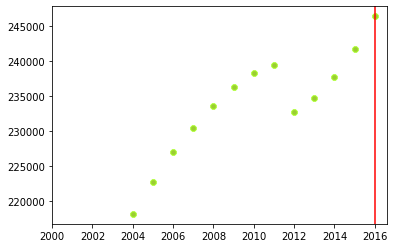

In [64]:
plt.scatter(case_3503['year'],case_3503['population'] ,color='greenyellow', marker='8',facecolor='yellowgreen')
plt.xticks(list(range(2000,2017,2)))
plt.axvline(2016,color='red')
preds_lin = np.expm1(regr_vol_5.predict(X_valid))

In [71]:
## add to scoreboard

In [67]:
from sklearn.linear_model import Lasso, ElasticNet

In [68]:
model_lasso = Lasso()
model_lasso.fit(X_train, y_train)
print_score(model_lasso,X_train, X_valid,y_train, y_valid)

('RMSE Train set: 260.94823139, RMSE Validation set: 271.85891589, '
 'r² Train set: 0.61820082, r² Validation set:0.5974803,         '
 'MAE Train set: 158.02820207, MAE Validation set: 163.60415407')


In [69]:
model_elastico = ElasticNet()
model_elastico.fit(X_train, y_train)
print_score(model_elastico,X_train, X_valid,y_train, y_valid)

('RMSE Train set: 281.42227657, RMSE Validation set: 290.28441233, '
 'r² Train set: 0.5559384, r² Validation set:0.54106899,         '
 'MAE Train set: 148.08318282, MAE Validation set: 152.96328844')


In [70]:
# Data set preparation time: 23 HOURS
# Preprocessing and modeling: 29 HOURS